In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
%matplotlib inline

import warnings
warnings.simplefilter("ignore")

## Data

In [2]:
data_train = pd.read_csv('data/train.csv')
X_test = pd.read_csv('data/test.csv')
data = data_train.append(X_test, ignore_index=True, sort=False)

In [3]:
data = data.drop(columns = ['PoolQC', 'MiscFeature','Alley','Fence','FireplaceQu'])

In [4]:
data = pd.get_dummies(data, dummy_na=True, drop_first=True)
data.drop('Id', axis=1, inplace=True)
data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,60,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,...,0,0,1,0,0,0,0,1,0,0
1,20,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,...,0,0,1,0,0,0,0,1,0,0
2,60,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,...,0,0,1,0,0,0,0,1,0,0
3,70,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,...,0,0,1,0,0,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,...,0,0,1,0,0,0,0,1,0,0


## Handling Missing Values:

In [5]:
data.fillna(data.median(), inplace=True)
columns = data.columns
sale_price = data["SalePrice"]
data.isnull().values.any()

False

In [6]:
data.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       ...
       'SaleType_New', 'SaleType_Oth', 'SaleType_WD', 'SaleType_nan',
       'SaleCondition_AdjLand', 'SaleCondition_Alloca', 'SaleCondition_Family',
       'SaleCondition_Normal', 'SaleCondition_Partial', 'SaleCondition_nan'],
      dtype='object', length=271)

## Handling the Outliers


In [7]:
outliers = data[
    (data['GrLivArea'] > 4000) &
    (data['SalePrice'] < 300000)&
    (data['LotArea'] > 100000) &
    (data['TotalBsmtSF'] > 3000) &
    (data['1stFlrSF'] > 2500)]

data.drop(outliers.index, inplace=True)

## Scaling the dataset

In [8]:
scaler = StandardScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns = columns)
data['SalePrice'] = sale_price
data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
0,0.067331,-0.191815,-0.217879,0.646183,-0.507284,1.046258,0.896833,0.529034,0.580959,-0.293025,...,-0.298629,-0.049029,0.395018,-0.018512,-0.064249,-0.09105,-0.126535,0.463937,-0.302693,0.0
1,-0.873616,0.511940,-0.072044,-0.063185,2.188279,0.154764,-0.395604,-0.567016,1.178162,-0.293025,...,-0.298629,-0.049029,0.395018,-0.018512,-0.064249,-0.09105,-0.126535,0.463937,-0.302693,0.0
2,0.067331,-0.051064,0.137197,0.646183,-0.507284,0.980221,0.848965,0.338903,0.097928,-0.293025,...,-0.298629,-0.049029,0.395018,-0.018512,-0.064249,-0.09105,-0.126535,0.463937,-0.302693,0.0
3,0.302568,-0.426400,-0.078385,0.646183,-0.507284,-1.859351,-0.682812,-0.567016,-0.494884,-0.293025,...,-0.298629,-0.049029,0.395018,-0.018512,-0.064249,-0.09105,-0.126535,-2.155466,-0.302693,0.0
4,0.067331,0.699608,0.518903,1.355551,-0.507284,0.947203,0.753229,1.390216,0.468984,-0.293025,...,-0.298629,-0.049029,0.395018,-0.018512,-0.064249,-0.09105,-0.126535,0.463937,-0.302693,0.0


In [9]:
data.shape

(2919, 271)

In [10]:
data.SalePrice

0       208500.0
1       181500.0
2       223500.0
3       140000.0
4       250000.0
          ...   
2914    163000.0
2915    163000.0
2916    163000.0
2917    163000.0
2918    163000.0
Name: SalePrice, Length: 2919, dtype: float64

## Dividing the data into train and test data

In [11]:
train = data.iloc[:1460]; 
test = data.iloc[1460:];
test.drop('SalePrice', axis=1, inplace=True)

## Splitting and transforming data

In [12]:
X_train, X_val, y_train, y_val = train_test_split(train.drop('SalePrice', axis=1), train['SalePrice'], test_size=0.25, random_state=42)

## Creating tensors 

In [13]:
train_batch = np.array_split(X_train, 100)
label_batch = np.array_split(y_train, 100)

In [14]:
for i in range(len(train_batch)):
    train_batch[i] = torch.from_numpy(train_batch[i].values).float()
for i in range(len(label_batch)):
    label_batch[i] = torch.from_numpy(label_batch[i].values).float().view(-1, 1)

X_val = torch.from_numpy(X_val.values).float()
y_val = torch.from_numpy(y_val.values).float().view(-1, 1)

In [15]:
X_train.shape

(1095, 270)

## Model

In [16]:
model = nn.Sequential(nn.Linear(270,102),
                      nn.LeakyReLU(),
                      nn.Dropout(0.5),
                      nn.Linear(102,50),
                      nn.LeakyReLU(),
                      nn.Dropout(0.5),
                      nn.Linear(50,1),
                      nn.LeakyReLU()
)


#criterion = nn.MSELoss()
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [17]:
model

Sequential(
  (0): Linear(in_features=270, out_features=102, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=102, out_features=50, bias=True)
  (4): LeakyReLU(negative_slope=0.01)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=50, out_features=1, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
)

In [18]:
ps = model(train_batch[0])
ps.shape

torch.Size([11, 1])

## Training 

In [19]:
epochs = 100
test_loss_min = np.Inf
train_losses, test_losses = [], []
for e in range(epochs):
    model.train()
    train_loss = 0
    for i in range(len(train_batch)):
        optimizer.zero_grad()
        output = model(train_batch[i])
        loss = torch.sqrt(criterion(output, label_batch[i]))
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        with torch.no_grad():
            model.eval()
            predictions = model(X_val)
            test_loss += torch.sqrt(criterion(predictions, y_val))
                
        train_losses.append(train_loss/len(train_batch))
        test_losses.append(test_loss)

        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(train_loss/len(train_batch)),
              "Test Loss: {:.3f}.. ".format(test_loss))
        
        if test_loss <= test_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            test_loss_min,
            test_loss))
            torch.save(model.state_dict(), 'model.pt')
            test_loss_min = test_loss

Epoch: 1/100..  Training Loss: 409.051..  Test Loss: 333.401.. 
Validation loss decreased (inf --> 333.401154).  Saving model ...
Epoch: 2/100..  Training Loss: 265.441..  Test Loss: 229.020.. 
Validation loss decreased (333.401154 --> 229.020355).  Saving model ...
Epoch: 3/100..  Training Loss: 240.131..  Test Loss: 207.942.. 
Validation loss decreased (229.020355 --> 207.941650).  Saving model ...
Epoch: 4/100..  Training Loss: 232.049..  Test Loss: 204.791.. 
Validation loss decreased (207.941650 --> 204.790588).  Saving model ...
Epoch: 5/100..  Training Loss: 229.851..  Test Loss: 197.065.. 
Validation loss decreased (204.790588 --> 197.065079).  Saving model ...
Epoch: 6/100..  Training Loss: 223.029..  Test Loss: 194.432.. 
Validation loss decreased (197.065079 --> 194.431900).  Saving model ...
Epoch: 7/100..  Training Loss: 220.250..  Test Loss: 191.439.. 
Validation loss decreased (194.431900 --> 191.439133).  Saving model ...
Epoch: 8/100..  Training Loss: 216.684..  Test L

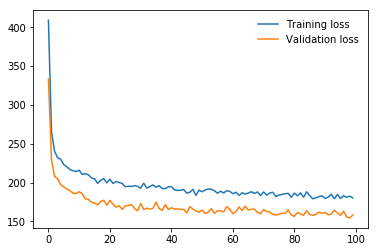

In [20]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [21]:
test = torch.from_numpy(test.values).float()
model.eval()
output = model.forward(test)
output.shape

torch.Size([1459, 1])

# Submission

In [22]:
submission = pd.read_csv('data/sample_submission.csv')
submission['SalePrice'] = output.detach().numpy()
submission.to_csv('submission#10.csv', index=False)

In [23]:
submission.head()

,Id,SalePrice
0,1461,119627.867188
1,1462,157673.328125
2,1463,176204.718750
3,1464,190524.203125
4,1465,186755.171875
